In [1]:
import torch

In [28]:
def ret_parallel_forward(q, k, v, state=None):
    # q, k, v: B, H, T, D
    B, H, T, D = q.shape
    mask = torch.tril(torch.ones(T, T, dtype=bool)) # causal masking
    attn = mask*(q@k.mT)
    out = attn@v 
    state_n = k.mT @ v
    if state is not None:
        out = out + q @ state
        state_n = state_n + state
    return out, state_n
def ret_recurrent_forward(q, k, v, state=None):
    # q, k, v: B, H, 1, D
    # state: B, H, D, D
    B, H, _, D = q.shape
    if state is None:
        state = torch.zeros(B, H, D, D)
    state = state + k.mT * v # B, H, D, D
    out = q@state
    return out, state

torch.manual_seed(0)
b, h, t, d = 16, 12, 100, 32
q, k, v = torch.randn(b, h, t, d), torch.randn(b, h, t, d), torch.randn(b, h, t, d)

# ------ PARALLEL FORWARD ------ 
out1, _ = ret_parallel_forward(q, k, v)

# ------ RECURRENT FORWARD ------ 
out2 = torch.zeros_like(out1)
state = None
for t in range(q.shape[2]):
    out2[:, :, [t]], state = ret_recurrent_forward(q[:, :, [t]], k[:, :, [t]], v[:, :, [t]], state=state)
print(torch.allclose(out1, out2, atol=1e-4))

# ------ BLOCK FORWARD ------ 
a, state = ret_parallel_forward(q[:, :, :50], k[:, :, :50], v[:, :, :50], state=None)
b, state = ret_parallel_forward(q[:, :, 50:], k[:, :, 50:], v[:, :, 50:], state=state)
out3 = torch.cat([a, b], dim=2)

print(torch.allclose(out2, out3, atol=1e-4))


True
True


In [31]:
def ret_parallel_forward(q, k, v, state=None):
    # q, k, v: B, H, T, D
    B, H, T, D = q.shape
    if state is None:
        state = torch.zeros(B, H, D, D)
    mask = torch.tril(torch.ones(T, T, dtype=bool))  # causal masking
    attn = mask*(q@k.mT)
    out = attn@v + q @ state
    state = k.mT @ v + state
    return out, state

torch.manual_seed(0)
b, h, t, d = 16, 12, 100, 32
q, k, v = torch.randn(b, h, t, d), torch.randn(b, h, t, d), torch.randn(b, h, t, d)

# ------ PARALLEL FORWARD ------ 
out1, _ = ret_parallel_forward(q, k, v)

# ------ RECURRENT FORWARD ------ 
out2 = torch.zeros_like(out1)
state = None
for t in range(q.shape[2]):
    out2[:, :, [t]], state = ret_parallel_forward(q[:, :, [t]], k[:, :, [t]], v[:, :, [t]], state=state)
print(torch.allclose(out1, out2, atol=1e-4))

# ------ BLOCK FORWARD ------ 
a, state = ret_parallel_forward(q[:, :, :30], k[:, :, :30], v[:, :, :30], state=None)
b, state = ret_parallel_forward(q[:, :, 30:60], k[:, :, 30:60], v[:, :, 30:60], state=state)
c, state = ret_parallel_forward(q[:, :, 60:], k[:, :, 60:], v[:, :, 60:], state=state)
out3 = torch.cat([a, b, c], dim=2)

print(torch.allclose(out2, out3, atol=1e-4))

True
True


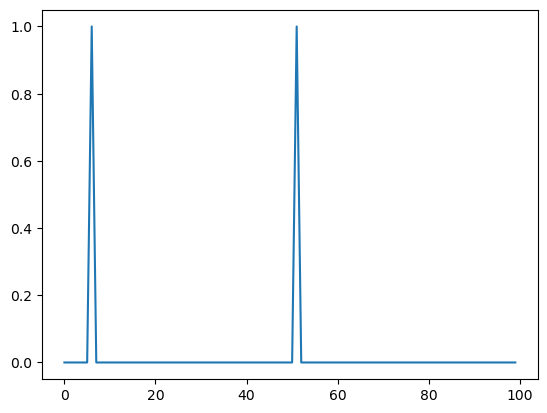

In [2]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

rng = jax.random.PRNGKey(3)
done = jax.random.uniform(rng, (100, )) < 0.05
plt.plot(done)
# print(done)

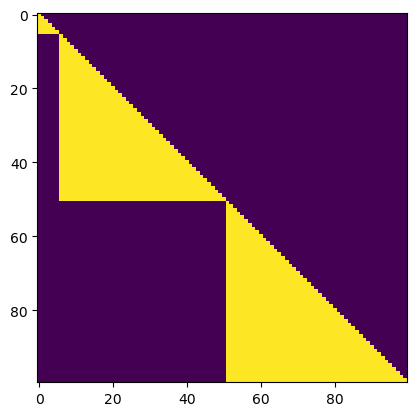

In [30]:
def make_attn_mask1(done):
    T, = done.shape
    mask_causal = jnp.tril(jnp.ones((T, T), dtype=bool))
    y, x = jnp.arange(T)[:, None], jnp.arange(T)[None, :]
    def f(mask, i):
        mask_now = ~((y>=i) * (x<i))
        mask_now = jax.lax.select(done[i], mask_now, mask_causal)
        return mask * mask_now, None
    mask, _ = jax.lax.scan(f, mask_causal, jnp.arange(T))
    return mask

def make_attn_mask2(done):
    T, = done.shape
    mask_causal = jnp.tril(jnp.ones((T, T), dtype=bool))
    def make_attn_mask_single(i, done_i):
        return mask_causal.at[i:, :i].set(1-done_i)
    mask = mask_causal
    for i in range(T):
        mask = mask * make_attn_mask_single(i, done[i])
    return mask
    
    
a = make_attn_mask1(done)
plt.imshow(a)